# Assignment 11
## name : rocky kim 
## student id : 20152424
## github link :[https://github.com/Epicevent/assignment11](https://github.com/Epicevent/assignment11 ) 

# denosing model 

$$
f = u + η 
$$


where f is an input noisy image, u is a desired
reconstruction, and η is a noise process


$$
η ∼ N (0, σ^2 ) 
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import sparse as sp
from skimage import io, color
from skimage import exposure

file_image	= 'cau.jpg'

im_color 	= io.imread(file_image)
im_gray  	= color.rgb2gray(im_color)
im          = (im_gray - np.mean(im_gray)) / np.std(im_gray)
(rows, cols)  = im.shape

def noise_process(noise_std):# try with varying noise standard deviation
    noise       = np.random.normal(0, noise_std, (rows, cols))
    im_noise    = im + noise
    return im_noise


def imshow(im_recon,im_noise,i,ltstr):
   
    fig = plt.figure(i) 
    # title 
    st = fig.suptitle(ltstr, fontsize="large")
    # obtain the reconstructed (denoised) images with varying degrees of regularization 
    noise_recon = im_noise - im_recon
    p1 = fig.add_subplot(2,2,1)
    p1.set_title('original image')
    p1.imshow(im, cmap='gray')
    p1.axis('off')

    p2 = fig.add_subplot(2,2,2)
    p2.set_title('noisy image')
    p2.imshow(im_noise, cmap='gray')
    p2.axis('off')

    p3 = fig.add_subplot(2,2,3)
    p3.set_title('reconstruction')
    p3.imshow(im_recon, cmap='gray')
    p3.axis('off')

    p4 = fig.add_subplot(2,2,4)
    p4.set_title('estimated noise')
    p4.imshow(noise_recon, cmap='gray')
    p4.axis('off')
    #plt.show()
    
# test code 
im_recon_test = im # this must be replaced with the reconstructed (denoised) image 
imshow(im_recon_test,noise_process(0.2),100,"TEST" )

# vectorize and linear model for solve problem


our linear model is ... 
$$
\epsilon(u; \lambda) = \| u − f \|_2^2 + \lambda \| \nabla u  \|_2^2
$$


# notation : vec(f) = y ,vec(u)= x 


$$
f,u \in \mathbb{R}^{n\times m }
$$

$$
y,x \in \mathbb{R}^{nm} 
$$

$$
\|\text{I}x - y\|^2  = \|u-f\|_2^2
$$


$$
\|\text{D}_hx + \text{D}_v x\|^2  = \|  \nabla u  \|_2^2
$$

In [2]:
def vectorize(A):
    return (A.flatten('F')).reshape(-1,1)

# definition of D matrix 

note that rows = n , cols = m 


$$
D_h =   \left[ I_{nm-n} {\begin{array}{ccccc}
   0 \cdots 0 \\
   \vdots \vdots \vdots  \\
   0 \cdots 0 
  \end{array}}  \right] - \left[{\begin{array}{ccccc}
   0 \cdots 0 \\
   \vdots \vdots \vdots  \\
   0 \cdots 0 
  \end{array}}  I_{nm-n}  \right] \in \mathbb{R}^{(nm-n) \times nm }
$$


$$
D_{v} =   \left[{\begin{array}{ccccc}
   B_v  O O \cdots O  \\
    O B_v O \cdots O  \\
   O  O  \ddots O O  \\
   O  O  \cdots O B_v  \end{array}}  \right] = I_{m} \otimes B_v
$$


$$
B_{v}= \text{A Block of }D_{v} =   \left[ I_{n-1} {\begin{array}{ccccc}
   0  \\
  \vdots  \\
   0  \end{array}}  \right] 
   - \left[{\begin{array}{ccccc}
   0 \\
   \vdots  \\
   0 \end{array}} I_{n-1}  \right] \in \mathbb{R}^{(n-1) \times n }
$$

In [3]:
def sparce_Dmatrix(n,m):
    D_h1 = sp.hstack(
        [sp.eye(n*m-n, format="csr"),  
         sp.csr_matrix((n*m-n, n))]) 
    D_h2 = sp.hstack(
        [sp.csr_matrix((n*m-n, n)),
         sp.eye(n*m-n, format="csr")])
    B_v1 =  sp.hstack(
        [sp.eye(n-1, format="csr"),sp.csr_matrix((n-1, 1))]) 
    B_v2 = sp.hstack(
        [sp.csr_matrix((n-1, 1)),
         sp.eye(n-1, format="csr")])
    # B_v ,D_v .D_h
    D_h =D_h1 - D_h2
    B_v = B_v1 - B_v2
    D_v = sp.kron(sp.eye(m),B_v)
    return D_v, D_h 


# definition of least square problem 


$$
\epsilon(u; \lambda) = \| u − f \|_2^2 + \lambda \| \nabla u  \|_2^2
= 
\|\text{I}x - y\|^2 + 
\lambda \|\text{D}_hx + \text{D}_v x\|^2 
$$


$$
A = \left[{\begin{array}{ccccc}
    \sqrt{\lambda}I_{nm} \\
    \sqrt{\lambda}D_v  \\
    \sqrt{\lambda}D_h \end{array}} \right]
$$


$$
b =  \left[{\begin{array}{ccccc}
    y \\
    0_{nm - m }   \\
    0_{nm-n} \end{array}} \right]
$$


$$
\| Ax - b \|^2
$$

In [4]:
def makeA(lada):
    root_lambda=np.power(lada,0.5)
    # using sparse matrix 
    a = root_lambda*sp.eye(rows*cols)
    D_v,D_h = sparce_Dmatrix(rows,cols)
    b = root_lambda*D_v
    c = root_lambda*D_h
    return sp.vstack([a,b,c])
# deffinition of b
def makeb(y):
    y = sp.csr_matrix(y)
    b = sp.vstack([y, sp.csr_matrix((2*rows*cols-rows-cols,1))])
    return b

In [5]:
def solve_least_square(A,b):
    b = b.toarray()
    b = np.squeeze(b)
    x, istop, itn, normr = sp.linalg.lsmr(A, b)[:4]
    return x ,normr

In [6]:
def calculate_x_and_error(lambda_,sigma_):
    return  solve_least_square(makeA(lambda_),makeb(vectorize(noise_process(sigma_))))

# Try with varying the noise standard deviation σ and the regularization parameter λ

In [7]:
# test set 
sigma_set = np.array([0.2,0.7,1])
lambda_set = np.array([ np.power(2,np.float(i))for i in range(-3,4)])
lambda_grid,sigma_grid  = np.meshgrid( lambda_set,sigma_set, sparse=False)
def get_x_and_error(sigma_grid,lambda_grid):
    (n , m)  =np.shape(sigma_grid)
    x_grid=np.zeros((n,m,rows*cols))
    error_grid = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            x_grid[i,j,:] , error_grid[i,j] =calculate_x_and_error(lambda_grid[i,j],sigma_grid[i,j])
    return x_grid, error_grid

# Present the reconstruction image with varying regularization

C:\Users\rocky\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


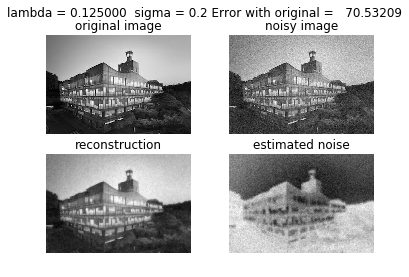

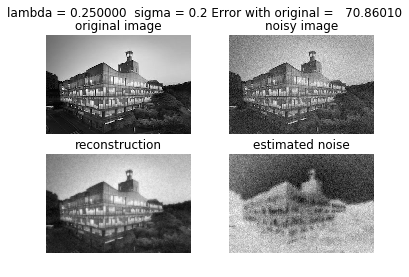

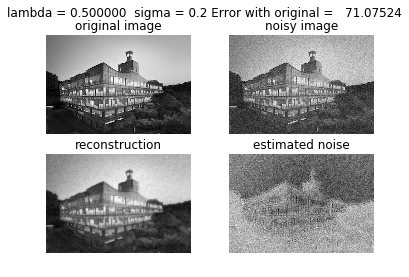

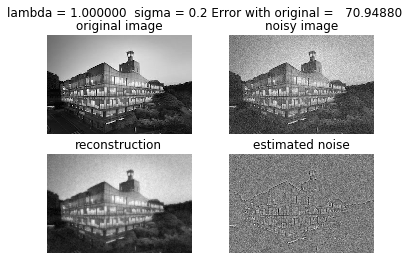

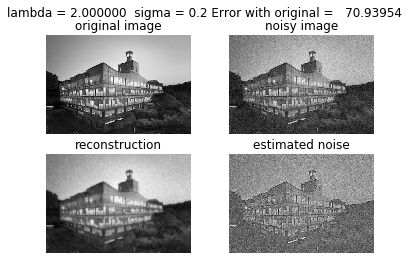

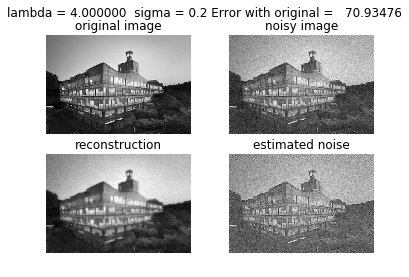

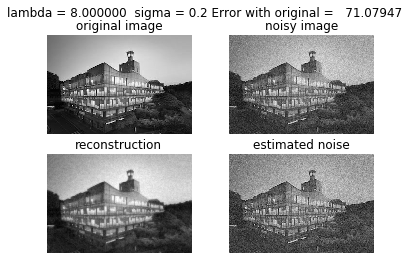

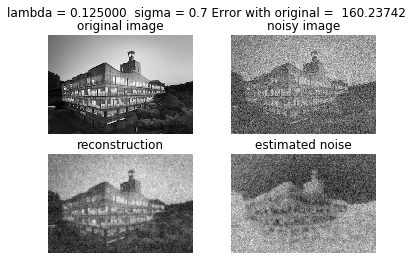

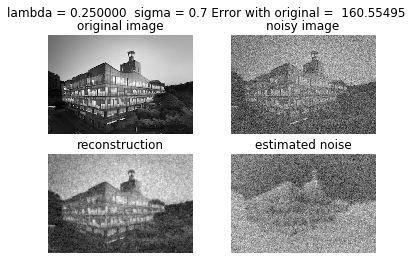

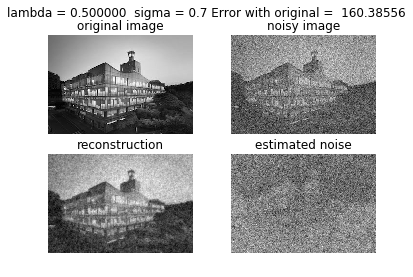

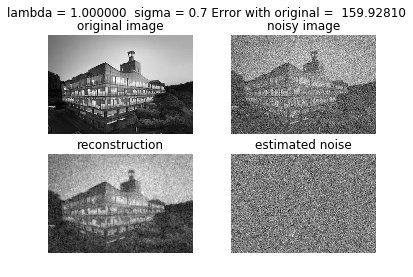

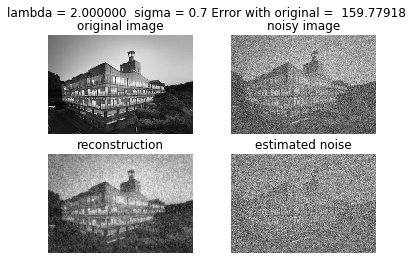

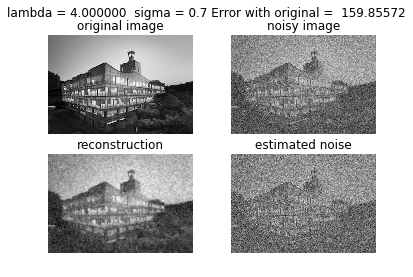

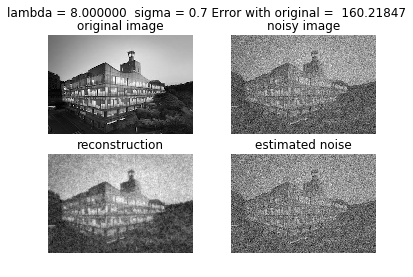

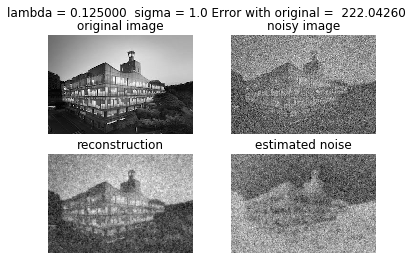

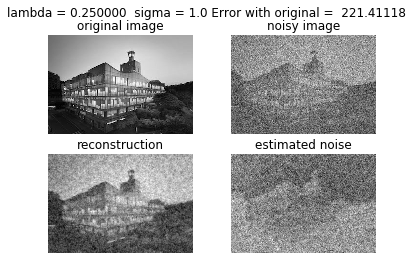

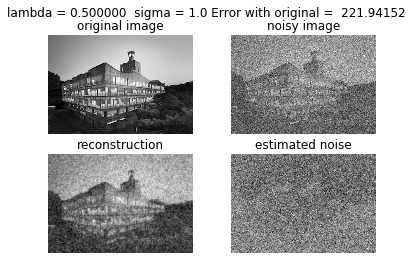

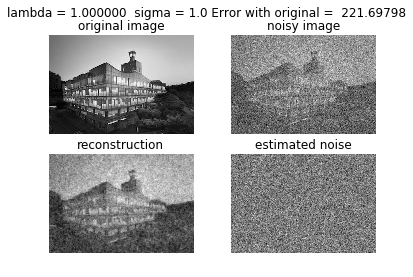

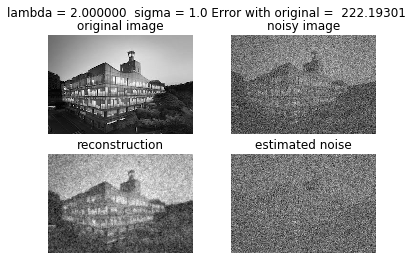

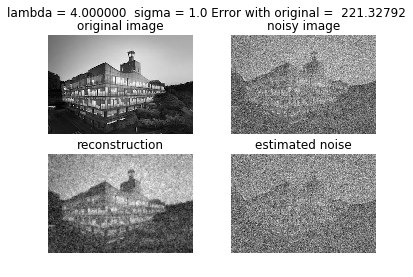

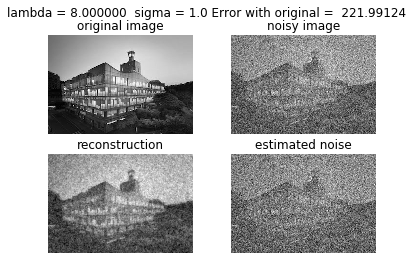

In [8]:
x_grid, error_grid = get_x_and_error(sigma_grid,lambda_grid)
(n , m)  =np.shape(error_grid)
for i in range (n):
    for j in range(m):       
        imrecon=x_grid[i,j,:].reshape(rows,cols,order='F')
        imnoise = noise_process(sigma_grid[i,j])
        large_title =  ("lambda = {:f}  sigma = {:2.1f} Error with original = {:10.5f}".format(
            lambda_grid[i,j],sigma_grid[i,j], error_grid[i,j]))
        imshow(imrecon,imnoise,m*i+j,large_title)

# Present the reconstruction error E(u;λ) with varying regularization parameter λ

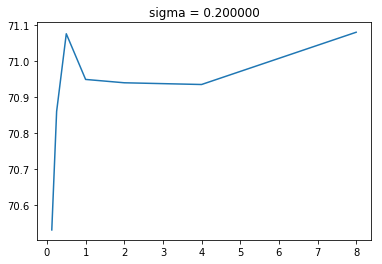

In [9]:
plt.title("sigma = {:f}".format(sigma_grid[0,0]))
plt.plot(lambda_grid[0,:], error_grid[0,:])        # reconstruction error

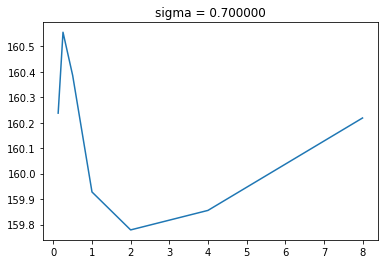

In [10]:
plt.title("sigma = {:f}".format(sigma_grid[1,0]))
plt.plot(lambda_grid[1,:], error_grid[1,:])        # reconstruction error

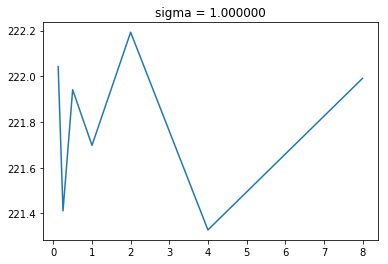

In [11]:
plt.title("sigma = {:f}".format(sigma_grid[2,0]))
plt.plot(lambda_grid[2,:], error_grid[2,:])        # reconstruction error